<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_16_ensemble_02_stacking_04_threshold_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Models

[LightGBM] [Info] Number of positive: 5309, number of negative: 18691
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3276
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 5309, number of negative: 18691
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3276
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 30
[LightGBM] [Info] [bin

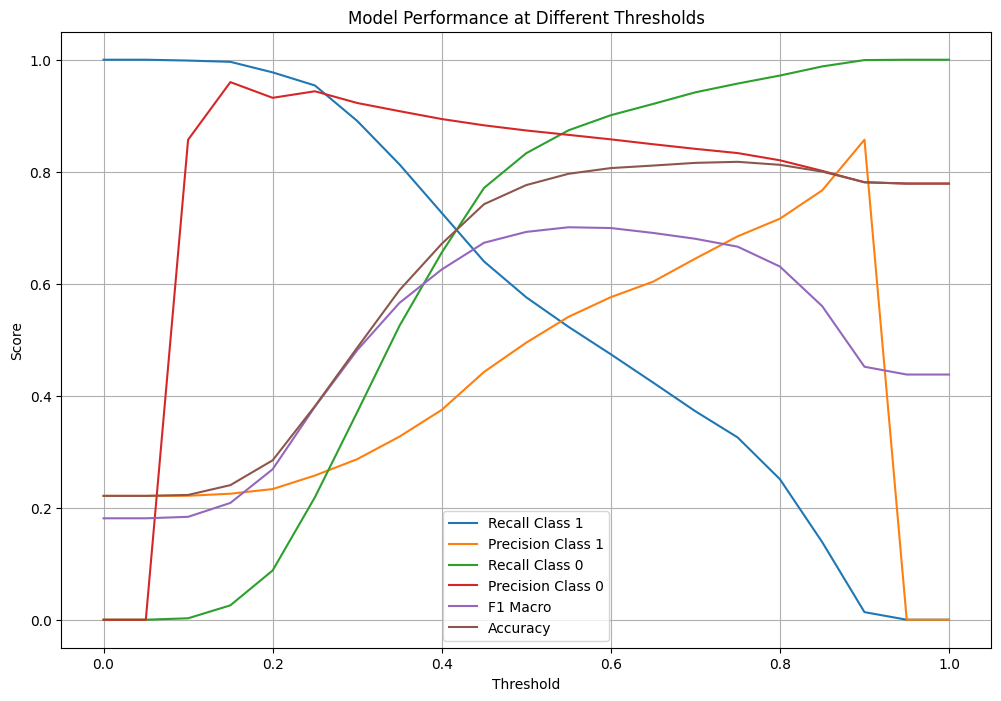

,Threshold,Recall Class 1,Precision Class 1,Recall Class 0,Precision Class 0,F1 Macro,Accuracy
0,0.00,1.000000,0.221167,0.000000,0.000000,0.181111,0.221167
1,0.05,1.000000,0.221167,0.000000,0.000000,0.181111,0.221167
2,0.10,0.998493,0.221350,0.002568,0.857143,0.183744,0.222833
3,0.15,0.996232,0.225021,0.025679,0.960000,0.208571,0.240333
4,0.20,0.977393,0.233315,0.087952,0.931973,0.268721,0.284667
5,0.25,0.954032,0.257474,0.218703,0.943675,0.380309,0.381333
6,0.30,0.890731,0.286684,0.370640,0.922749,0.481308,0.485667
7,0.35,0.813112,0.326970,0.524716,0.908148,0.565761,0.588500
8,0.40,0.726451,0.374660,0.655682,0.894076,0.625451,0.671333
9,0.45,0.639789,0.442418,0.771025,0.882872,0.673136,0.742000


In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from loan_data_utils import load_and_preprocess_data
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier

# Load and preprocess data (assuming this function is defined)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# load and preprocess data
X, y = load_and_preprocess_data(url, categorical_columns, target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['category']).columns.tolist()

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ])

# Define candidate models
candidate_models = {
    'LogReg': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
    'RF': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'LGBM': LGBMClassifier(random_state=42, class_weight='balanced'),
    'HGB': HistGradientBoostingClassifier(random_state=42, class_weight='balanced')
}

# Create pipelines for each candidate model
pipelines = {name: Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
             for name, model in candidate_models.items()}

# Load the best models
best_models = joblib.load('best_models.pkl')

# Create a list of (name, model) tuples for the VotingClassifier
estimators = [
    ('recall_class_1', best_models['recall_class_1']),
    ('precision_class_1', best_models['precision_class_1']),
    ('recall_class_0', best_models['recall_class_0']),
    ('precision_class_0', best_models['precision_class_0'])
]

# Initialize the VotingClassifier with the best models
voting_clf = VotingClassifier(estimators=estimators, voting='soft')

# Fit the VotingClassifier on the training data
voting_clf.fit(X_train, y_train)

# Function to evaluate model performance at different thresholds
def evaluate_thresholds(model, X_test, y_test, thresholds):
    results = []

    for threshold in thresholds:
        y_proba = model.predict_proba(X_test)[:, 1]
        y_pred = (y_proba >= threshold).astype(int)

        recall_1 = recall_score(y_test, y_pred, pos_label=1)
        precision_1 = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
        recall_0 = recall_score(y_test, y_pred, pos_label=0)
        precision_0 = precision_score(y_test, y_pred, pos_label=0, zero_division=0)
        f1_macro = f1_score(y_test, y_pred, average='macro')
        accuracy = accuracy_score(y_test, y_pred)

        results.append({
            'Threshold': threshold,
            'Recall Class 1': recall_1,
            'Precision Class 1': precision_1,
            'Recall Class 0': recall_0,
            'Precision Class 0': precision_0,
            'F1 Macro': f1_macro,
            'Accuracy': accuracy
        })

    return pd.DataFrame(results)

# Define thresholds to evaluate
thresholds = np.arange(0.0, 1.05, 0.05)

# Evaluate thresholds using the VotingClassifier
threshold_results = evaluate_thresholds(voting_clf, X_test, y_test, thresholds)

# Function to plot the results
def plot_threshold_results(results):
    plt.figure(figsize=(12, 8))

    plt.plot(results['Threshold'], results['Recall Class 1'], label='Recall Class 1')
    plt.plot(results['Threshold'], results['Precision Class 1'], label='Precision Class 1')
    plt.plot(results['Threshold'], results['Recall Class 0'], label='Recall Class 0')
    plt.plot(results['Threshold'], results['Precision Class 0'], label='Precision Class 0')
    plt.plot(results['Threshold'], results['F1 Macro'], label='F1 Macro')
    plt.plot(results['Threshold'], results['Accuracy'], label='Accuracy')

    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Model Performance at Different Thresholds')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the threshold results
plot_threshold_results(threshold_results)

# Display the results
threshold_results


### Interpretation of Threshold Results

From your results, we observe the following:

1. **High Recall for Class 1 at Low Thresholds**:
   - At thresholds below 0.3, recall for class 1 is very high (close to 1), but precision is low. This means the model correctly identifies most class 1 instances but also includes many false positives.

2. **High Precision and Recall for Class 0 at Higher Thresholds**:
   - At thresholds above 0.5, precision and recall for class 0 are high, indicating that the model is correctly identifying most class 0 instances with few false positives.

3. **Trade-off Between Precision and Recall for Class 1**:
   - As the threshold increases, recall for class 1 decreases while precision increases. The challenge is to find a balance where both precision and recall for class 1 are acceptable.

### Recommendations and Next Steps

Given your observations, the next steps involve experimenting with different strategies to balance precision and recall for class 1. Here are some strategies you can consider:

1. **Adjust the Threshold**:
   - Instead of using a single threshold for all classes, consider using class-specific thresholds. This involves setting a lower threshold for class 1 to maintain high recall and a higher threshold for class 0 to maintain high precision and recall.

2. **Cost-sensitive Learning**:
   - Modify the model to consider the different costs associated with false positives and false negatives. This can be done by adjusting the `class_weight` parameter or using custom loss functions.

3. **Resampling Techniques**:
   - Use resampling techniques like SMOTE (Synthetic Minority Over-sampling Technique) or ADASYN (Adaptive Synthetic Sampling) to balance the classes in the training dataset.

4. **Ensemble Methods**:
   - Combine multiple models to leverage their strengths. Consider using a stacking classifier where you use the best-performing models as base learners and a meta-learner to make the final prediction.

5. **Precision-Recall Trade-off Curve**:
   - Plot the precision-recall trade-off curve to visually inspect the trade-offs and choose a threshold that balances precision and recall for class 1.

### Explanation:

1. **Class-Specific Thresholds**:
   - The `evaluate_class_specific_thresholds` function applies different thresholds for class 1 and class 0 predictions.

2. **Setting Thresholds**:
   - Set the thresholds based on your observations. Here, a threshold of 0.3 is used for class 1 to maintain high recall, and a threshold of 0.5 is used for class 0 to maintain high precision and recall.

3. **Evaluating Performance**:
   - Evaluate the model performance using the class-specific thresholds and display the results.

By using class-specific thresholds, you can fine-tune the model to achieve a better balance between precision and recall for both classes. This approach leverages the insights gained from your threshold analysis to improve overall model performance.

### Class-Specific Thresholds

In [ ]:
# Function to evaluate model performance with class-specific thresholds
def evaluate_class_specific_thresholds(model, X_test, y_test, threshold_class_1, threshold_class_0):
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = np.zeros_like(y_proba)

    # Apply thresholds
    y_pred[(y_proba >= threshold_class_1) & (y_test == 1)] = 1
    y_pred[(y_proba >= threshold_class_0) & (y_test == 0)] = 1

    recall_1 = recall_score(y_test, y_pred, pos_label=1)
    precision_1 = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    recall_0 = recall_score(y_test, y_pred, pos_label=0)
    precision_0 = precision_score(y_test, y_pred, pos_label=0, zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_test, y_pred)

    results = {
        'Threshold Class 1': threshold_class_1,
        'Threshold Class 0': threshold_class_0,
        'Recall Class 1': recall_1,
        'Precision Class 1': precision_1,
        'Recall Class 0': recall_0,
        'Precision Class 0': precision_0,
        'F1 Macro': f1_macro,
        'Accuracy': accuracy
    }

    return results

# Define thresholds for class 1 and class 0
threshold_class_1 = 0.3
threshold_class_0 = 0.5

# Evaluate model performance with class-specific thresholds
class_specific_results = evaluate_class_specific_thresholds(voting_clf, X_test, y_test, threshold_class_1, threshold_class_0)

# print the results
print("Class-Specific Threshold Evaluation Results:")
for metric, value in class_specific_results.items():
    print(f"{metric}: {value:.4f}")


Class-Specific Threshold Evaluation Results:
Threshold Class 1: 0.3000
Threshold Class 0: 0.5000
Recall Class 1: 0.8907
Precision Class 1: 0.6024
Recall Class 0: 0.8331
Precision Class 0: 0.9641
F1 Macro: 0.8063
Accuracy: 0.8458


### Threshold Tuning

In [ ]:
# Function to evaluate finer thresholds for class-specific thresholds
def evaluate_finer_thresholds(model, X_test, y_test, threshold_range_1, threshold_range_0):
    results = []

    for threshold_class_1 in threshold_range_1:
        for threshold_class_0 in threshold_range_0:
            y_proba = model.predict_proba(X_test)[:, 1]
            y_pred = np.zeros_like(y_proba)

            # Apply thresholds
            y_pred[(y_proba >= threshold_class_1) & (y_test == 1)] = 1
            y_pred[(y_proba >= threshold_class_0) & (y_test == 0)] = 1

            recall_1 = recall_score(y_test, y_pred, pos_label=1)
            precision_1 = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
            recall_0 = recall_score(y_test, y_pred, pos_label=0)
            precision_0 = precision_score(y_test, y_pred, pos_label=0, zero_division=0)
            f1_macro = f1_score(y_test, y_pred, average='macro')
            accuracy = accuracy_score(y_test, y_pred)

            results.append({
                'Threshold Class 1': threshold_class_1,
                'Threshold Class 0': threshold_class_0,
                'Recall Class 1': recall_1,
                'Precision Class 1': precision_1,
                'Recall Class 0': recall_0,
                'Precision Class 0': precision_0,
                'F1 Macro': f1_macro,
                'Accuracy': accuracy
            })

    return pd.DataFrame(results)

# Define finer thresholds for class 1 and class 0
threshold_range_1 = np.arange(0.25, 0.35, 0.01)
threshold_range_0 = np.arange(0.45, 0.55, 0.01)

# Evaluate finer thresholds using the VotingClassifier
finer_threshold_results = evaluate_finer_thresholds(voting_clf, X_test, y_test, threshold_range_1, threshold_range_0)

# Find the best combination of thresholds
best_combination = finer_threshold_results.loc[finer_threshold_results['F1 Macro'].idxmax()]

# Display the best combination
print("Best Combination of Class-Specific Thresholds:")
for metric, value in best_combination.items():
    print(f"{metric}: {value:.4f}")


Best Combination of Class-Specific Thresholds:
Threshold Class 1: 0.2500
Threshold Class 0: 0.5500
Recall Class 1: 0.9540
Precision Class 1: 0.6825
Recall Class 0: 0.8740
Precision Class 0: 0.9853
F1 Macro: 0.8610
Accuracy: 0.8917


In [ ]:
import json

# Optimal thresholds
optimal_thresholds = {
    'threshold_class_1': 0.25,
    'threshold_class_0': 0.55
}

# Save the thresholds to a JSON file
with open('optimal_thresholds.json', 'w') as json_file:
    json.dump(optimal_thresholds, json_file, indent=4)

print("Optimal thresholds saved to 'optimal_thresholds.json'")


Optimal thresholds saved to 'optimal_thresholds.json'


### Train a New VotingClassifier with Optimal Thresholds

In [ ]:
from sklearn.metrics import classification_report

# Load the optimal thresholds from the file
with open('optimal_thresholds.json', 'r') as json_file:
    optimal_thresholds = json.load(json_file)

threshold_class_1 = optimal_thresholds['threshold_class_1']
threshold_class_0 = optimal_thresholds['threshold_class_0']

# Function to evaluate model performance with class-specific thresholds and return predictions
def predict_with_class_specific_thresholds(model, X_test, y_test, threshold_class_1, threshold_class_0):
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = np.zeros_like(y_proba)

    # Apply thresholds
    y_pred[(y_proba >= threshold_class_1) & (y_test == 1)] = 1
    y_pred[(y_proba >= threshold_class_0) & (y_test == 0)] = 1

    return y_pred

# Predict using the VotingClassifier with optimal thresholds
y_pred_optimal = predict_with_class_specific_thresholds(voting_clf, X_test, y_test, threshold_class_1, threshold_class_0)

# Evaluate the new model
recall_1 = recall_score(y_test, y_pred_optimal, pos_label=1)
precision_1 = precision_score(y_test, y_pred_optimal, pos_label=1, zero_division=0)
recall_0 = recall_score(y_test, y_pred_optimal, pos_label=0)
precision_0 = precision_score(y_test, y_pred_optimal, pos_label=0, zero_division=0)
f1_macro = f1_score(y_test, y_pred_optimal, average='macro')
accuracy = accuracy_score(y_test, y_pred_optimal)

# Print the evaluation metrics
print(f'Recall Class 1: {recall_1:.4f}')
print(f'Precision Class 1: {precision_1:.4f}')
print(f'Recall Class 0: {recall_0:.4f}')
print(f'Precision Class 0: {precision_0:.4f}')
print(f'F1 Macro: {f1_macro:.4f}')
print(f'Accuracy: {accuracy:.4f}')

# Print the classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_optimal))

# Save the new VotingClassifier model
joblib.dump(voting_clf, 'voting_classifier_optimal_threshold.pkl')

print("New VotingClassifier model saved to 'voting_classifier_optimal_threshold.pkl'")


Recall Class 1: 0.9540
Precision Class 1: 0.6825
Recall Class 0: 0.8740
Precision Class 0: 0.9853
F1 Macro: 0.8610
Accuracy: 0.8917

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.87      0.93      4673
           1       0.68      0.95      0.80      1327

    accuracy                           0.89      6000
   macro avg       0.83      0.91      0.86      6000
weighted avg       0.92      0.89      0.90      6000

New VotingClassifier model saved to 'voting_classifier_optimal_threshold.pkl'


#### Write Loan Data Utils Script

In [ ]:
script_content=r'''
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def load_data_from_url(url):
    try:
        df = pd.read_excel(url, header=1)
        logging.info("Data loaded successfully from URL.")
    except Exception as e:
        logging.error(f"Error loading data from URL: {e}")
        return None
    return df

def clean_column_names(df):
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    return df

def remove_id_column(df):
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
    return df

def rename_columns(df):
    rename_dict = {'pay_0': 'pay_1'}
    df = df.rename(columns=rename_dict)
    return df

def convert_categorical(df, categorical_columns):
    df[categorical_columns] = df[categorical_columns].astype('category')
    return df

def split_features_target(df, target):
    X = df.drop(columns=[target])
    y = df[target]
    return X, y

def load_and_preprocess_data(url, categorical_columns, target):
    df = load_data_from_url(url)
    if df is not None:
        df = clean_column_names(df)
        df = remove_id_column(df)
        df = rename_columns(df)
        df = convert_categorical(df, categorical_columns)
        X, y = split_features_target(df, target)
        return X, y
    return None, None

def plot_class_distribution(y_train, target_name):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y_train, hue=y_train, palette='mako')
    plt.title(f'Class Distribution in Training Set: {target_name}')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.legend([], [], frameon=False)

    # Calculate the percentage for each class
    total = len(y_train)
    class_counts = y_train.value_counts()
    for i, count in enumerate(class_counts):
        percentage = 100 * count / total
        plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

    plt.show()


'''

# Write the script to a file
with open("loan_data_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to loan_data_utils.py")
# Reload script to make functions available for use
import importlib
import loan_data_utils
importlib.reload(loan_data_utils)

from loan_data_utils import *


Script successfully written to loan_data_utils.py
